Num SAR tiles: 6181
Num MASK tiles: 6181
Matched SAR–Mask pairs: 6181
SAR only: 0
Mask only: 0


100%|█████████████| 6181/6181 [09:08<00:00, 11.27it/s]


Empty tiles: 0
Valid tiles: 6181


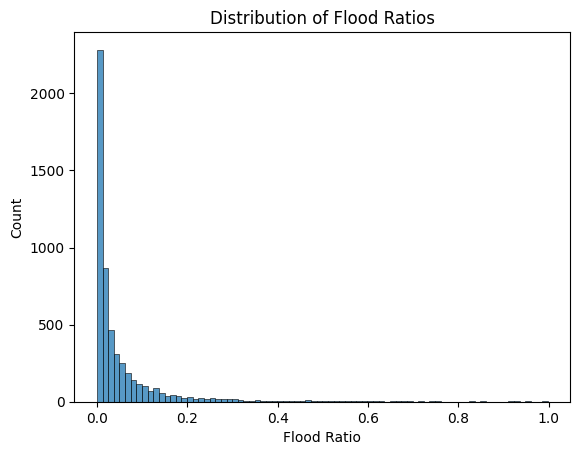

Tile with the highest flood ratio: /mnt/cephfs-mount/chenchen/mmflood_processed_v2/train/sar/EMSR199-4-7_1432_1425.tif
Flood ratio: 0.998077392578125


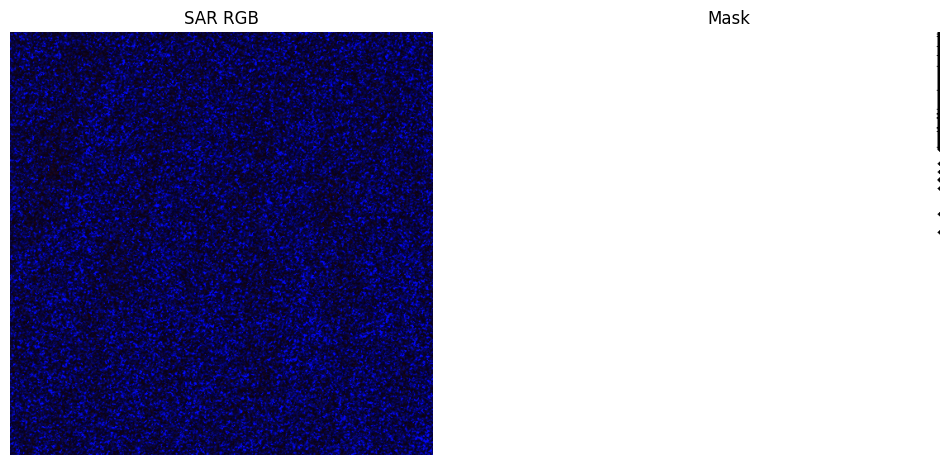

In [1]:
############################################################
# MMFLOOD VISUALIZATION SCRIPT 
############################################################

from glob import glob
from pathlib import Path
from matplotlib import pyplot as plt

import cv2
import numpy as np
import rasterio
from tqdm import tqdm
import seaborn as sns

############################################################
# 1. Set up paths based on your MMFlood directory structure
############################################################
DATA_ROOT = Path("/mnt/cephfs-mount/chenchen/mmflood_processed_v2")
SUBSET = "train"  # Options: "train", "val", "test"

SAR_DIR  = DATA_ROOT / SUBSET / "sar"
MASK_DIR = DATA_ROOT / SUBSET / "mask"

sar_paths_raw  = sorted(glob(str(SAR_DIR  / "*.tif")))
mask_paths_raw = sorted(glob(str(MASK_DIR / "*.tif")))

print("Num SAR tiles:", len(sar_paths_raw))
print("Num MASK tiles:", len(mask_paths_raw))

############################################################
# 2. Match SAR / MASK pairs by filename
############################################################

def get_id(p):
    """Return filename without extension, e.g., EMSR107-1-0_53_44"""
    return Path(p).stem

sar_dict  = {get_id(p): p for p in sar_paths_raw}
mask_dict = {get_id(p): p for p in mask_paths_raw}

common_ids = sorted(set(sar_dict.keys()) & set(mask_dict.keys()))
only_sar   = sorted(set(sar_dict.keys()) - set(mask_dict.keys()))
only_mask  = sorted(set(mask_dict.keys()) - set(sar_dict.keys()))

print("Matched SAR–Mask pairs:", len(common_ids))
print("SAR only:", len(only_sar))
print("Mask only:", len(only_mask))

assert len(common_ids) > 0, "No matched SAR/Mask pairs found! Check your filenames."

pairs = [(sar_dict[i], mask_dict[i]) for i in common_ids]

############################################################
# 3. Compute flood ratios for each tile
############################################################
ratios = []
area = 512 * 512
empty_tiles = 0

for sar_path, mask_path in tqdm(pairs):
    with rasterio.open(sar_path) as src:
        sar = src.read().transpose(1,2,0)

    with rasterio.open(mask_path) as src:
        mask = src.read().transpose(1,2,0)

    # Skip mostly empty tiles
    if np.count_nonzero(np.isnan(sar)) > area * 0.75:
        empty_tiles += 1
        continue

    values, counts = np.unique(mask, return_counts=True)
    flooded_ratio = counts[1] / float(area) if len(counts) == 2 else 0
    ratios.append((sar_path, mask_path, flooded_ratio))

print("Empty tiles:", empty_tiles)
print("Valid tiles:", len(ratios))

############################################################
# 4. Plot flood-ratio distribution
############################################################
sorted_ratios = sorted(ratios, key=lambda x: x[-1])

sns.histplot(
    np.array([x[-1] for x in sorted_ratios if x[-1] > 0]),
    bins=80
)
plt.title("Distribution of Flood Ratios")
plt.xlabel("Flood Ratio")
plt.ylabel("Count")
plt.show()

############################################################
# 5. Utility helpers (SAR → RGB visualization)
############################################################
def imread(path: Path) -> np.ndarray:
    with rasterio.open(str(path)) as ds:
        return ds.read().transpose(1,2,0)

def rgb_ratio(raw_sar):
    """Convert VV/VH SAR channels into pseudo RGB for visualization."""
    vv = raw_sar[:,:,0]
    vh = raw_sar[:,:,1]
    r = vv / 0.28
    g = vh / 0.06
    b = vh / (vv + 1e-6) / 0.49
    return np.clip(np.stack((r,g,b),axis=-1), 0, 1)

def plot_pair(sar_path, mask_path):
    sar = imread(sar_path)
    mask = imread(mask_path)

    fig, axes = plt.subplots(1,2, figsize=(12,6))
    axes[0].imshow(rgb_ratio(sar))
    axes[0].set_title("SAR RGB")
    axes[0].axis("off")

    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.show()

############################################################
# 6. Visualize the tile with the highest flood ratio
############################################################
best_sar, best_mask, best_ratio = sorted_ratios[-1]
print("Tile with the highest flood ratio:", best_sar)
print("Flood ratio:", best_ratio)

plot_pair(best_sar, best_mask)


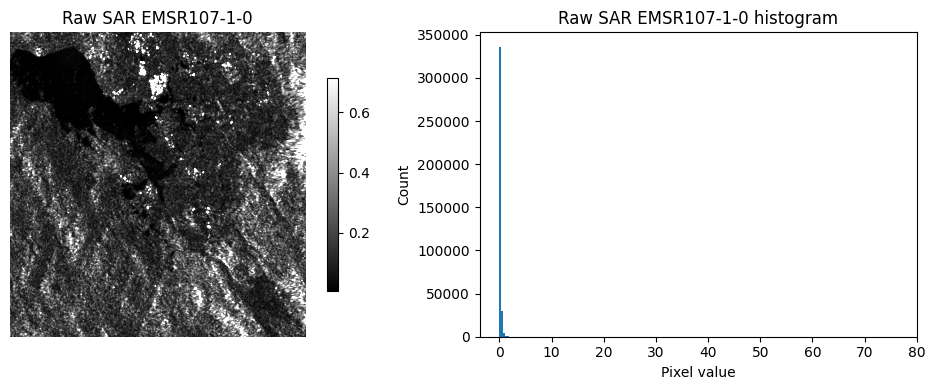

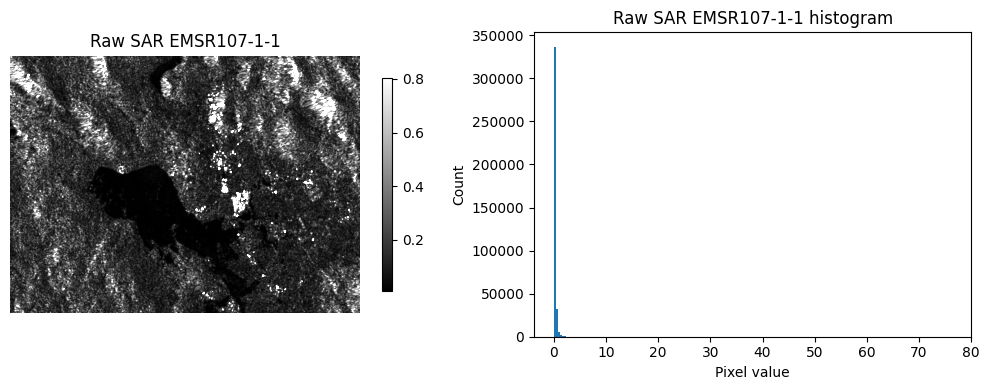

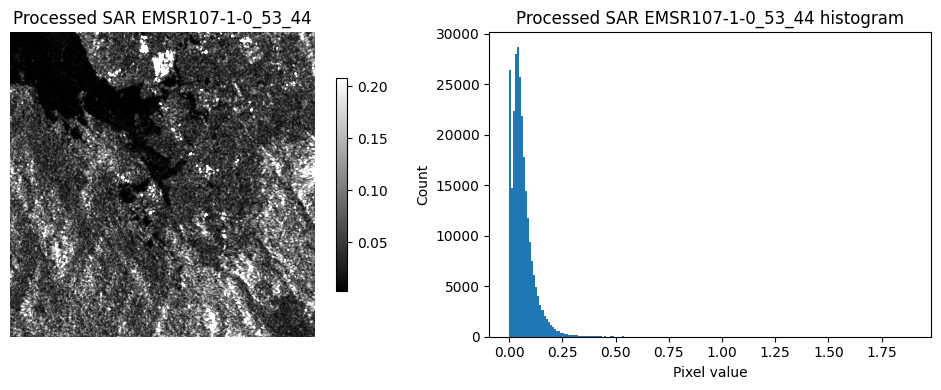

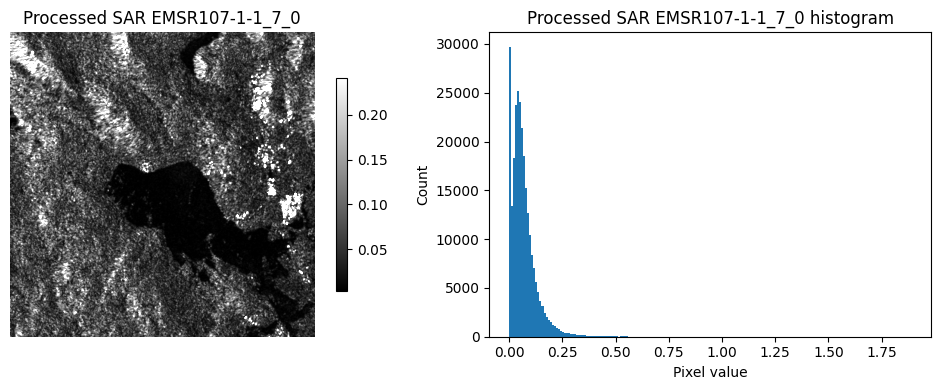

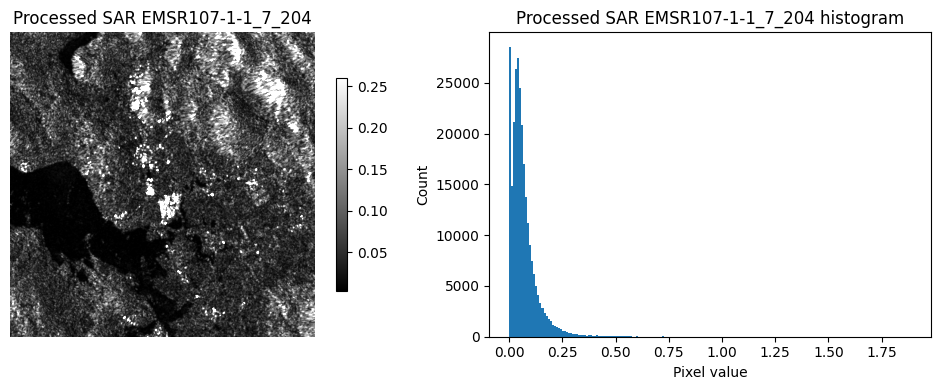

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

paths = [
    "/mnt/cephfs-mount/chenchen/mmflood/EMSR107-1/s1_raw/EMSR107-1-0.tif",
    "/mnt/cephfs-mount/chenchen/mmflood/EMSR107-1/s1_raw/EMSR107-1-1.tif",
    "/mnt/cephfs-mount/chenchen/mmflood_processed_v2/train/sar/EMSR107-1-0_53_44.tif",
    "/mnt/cephfs-mount/chenchen/mmflood_processed_v2/train/sar/EMSR107-1-1_7_0.tif",
    "/mnt/cephfs-mount/chenchen/mmflood_processed_v2/train/sar/EMSR107-1-1_7_204.tif",
]

titles = [
    "Raw SAR EMSR107-1-0",
    "Raw SAR EMSR107-1-1",
    "Processed SAR EMSR107-1-0_53_44",
    "Processed SAR EMSR107-1-1_7_0",
    "Processed SAR EMSR107-1-1_7_204",
]

for path, title in zip(paths, titles):
    with rasterio.open(path) as src:
        img = src.read(1).astype(float)

    vmin, vmax = np.percentile(img[np.isfinite(img)], [2, 98])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    im = ax1.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    ax1.set_title(title)
    ax1.axis("off")
    fig.colorbar(im, ax=ax1, shrink=0.7)

    ax2.hist(img.flatten(), bins=200)
    ax2.set_title(f"{title} histogram")
    ax2.set_xlabel("Pixel value")
    ax2.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


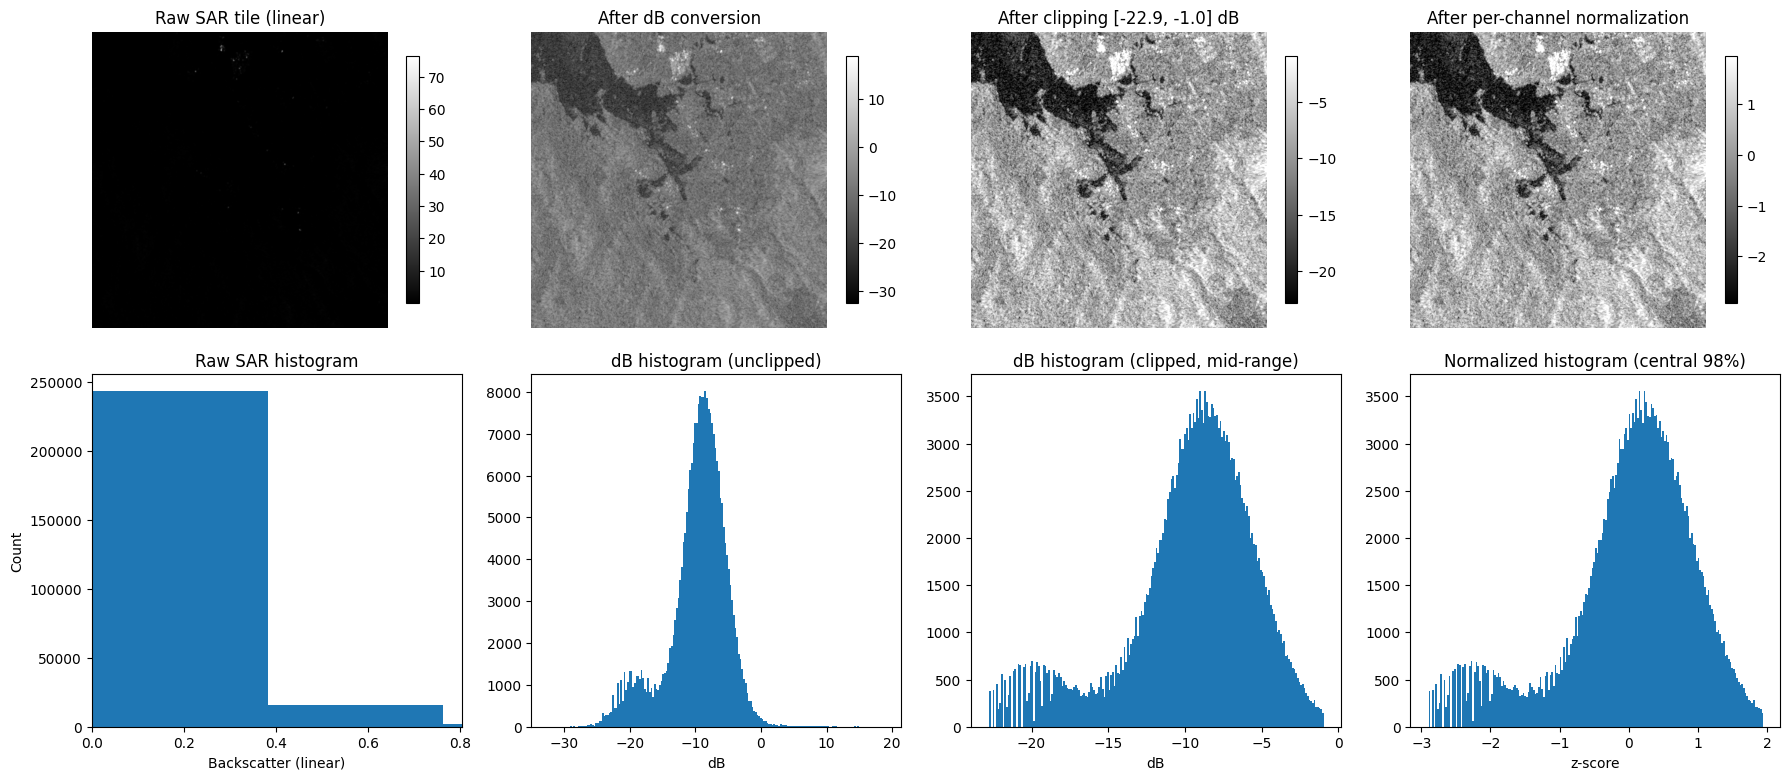

In [4]:
import numpy as np
import matplotlib.pyplot as plt

DB_MIN, DB_MAX = tile_db_clip.min(), tile_db_clip.max()

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
ax = axes.ravel()

# 1. Raw 
im0 = ax[0].imshow(raw_tile, cmap="gray")
ax[0].set_title("Raw SAR tile (linear)")
ax[0].axis("off")
fig.colorbar(im0, ax=ax[0], shrink=0.7)

# 1. Raw histogram
ax[4].hist(raw_tile.flatten(), bins=200)
ax[4].set_xlim(0, np.percentile(raw_tile, 99)) 
ax[4].set_title("Raw SAR histogram")
ax[4].set_xlabel("Backscatter (linear)")
ax[4].set_ylabel("Count")

# 2. dB 
im1 = ax[1].imshow(tile_db, cmap="gray")
ax[1].set_title("After dB conversion")
ax[1].axis("off")
fig.colorbar(im1, ax=ax[1], shrink=0.7)

# 2. dB histogram
ax[5].hist(tile_db.flatten(), bins=200)
ax[5].set_title("dB histogram (unclipped)")
ax[5].set_xlabel("dB")

# 3. clipped dB 
im2 = ax[2].imshow(tile_db_clip, cmap="gray", vmin=DB_MIN, vmax=DB_MAX)
ax[2].set_title(f"After clipping [{DB_MIN:.1f}, {DB_MAX:.1f}] dB")
ax[2].axis("off")
fig.colorbar(im2, ax=ax[2], shrink=0.7)

# 3. dB histogram
mask_mid = (tile_db_clip > DB_MIN) & (tile_db_clip < DB_MAX)
ax[6].hist(tile_db_clip[mask_mid].flatten(), bins=200)
ax[6].set_title("dB histogram (clipped, mid-range)")
ax[6].set_xlabel("dB")

# 4. normalized 
im3 = ax[3].imshow(tile_norm, cmap="gray")
ax[3].set_title("After per-channel normalization")
ax[3].axis("off")
fig.colorbar(im3, ax=ax[3], shrink=0.7)

# 4. normalized histogram
z_min, z_max = np.percentile(tile_norm, [1, 99])
mask_mid_z = (tile_norm > z_min) & (tile_norm < z_max)
ax[7].hist(tile_norm[mask_mid_z].flatten(), bins=200)
ax[7].set_title("Normalized histogram (central 98%)")
ax[7].set_xlabel("z-score")

plt.tight_layout()
plt.show()
